In [2]:
pip install biopython pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
from Bio import SeqIO, Align
from Bio.Blast import NCBIXML
from Bio.Blast.Applications import NcbiblastnCommandline
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import gzip, os, shutil
from progressBar import printProgressBar

In [4]:
###Requirements:
# Blast executables
# Fastq to Fasta conversion (MagicBlast)
""" Starter stuff """
aln = Align.PairwiseAligner()

###NOTE: Assumes that all samples are in gzipped fastq format and that reference genome is in cwd

master_dir = '/home/ddooley/sequencing/12_24_LB_TSB_YPD_MYD/fastq_pass'
ref_path = os.getcwd() + '/' + input("\nPlease give the name of your reference genome(s): ")

""" Step 1: Make blastdb """
db_name = input("\nPlease give your blast DB a name: ")
db_cline = "makeblastdb -in " + ref_path + " -dbtype nucl -out " + db_name ###Set up argument for making blast DB
os.system(db_cline) ###Make blast db
l_tot = len(os.listdir(master_dir))

""" Step 2: Loop Through Every Barcode Dir and Get Read Hits """
master_df = pd.DataFrame()
for it, barcode_dir in enumerate(sorted(os.listdir(master_dir))): ###MASTER LOOP THROUGH EVERY DIRECTORY IN SEQUENCING FOLDER
    barcode_dir = master_dir + '/' + barcode_dir
    l = len(os.listdir(barcode_dir))
    print('\nNow in %s directory...%.0f%% complete!' % (barcode_dir.split("/")[-1], ((it/l_tot)*100)))
    
    """ Step 2.1: Extract all FASTQ Data """
    fasta_paths = []
    print('\nConverting fastq to fasta for %s...' % barcode_dir.split("/")[-1])
    printProgressBar(0, l, prefix = 'Progress:', suffix = 'Complete', length = 50) ###Initialize progress bar
    for i, filename in enumerate(sorted(os.listdir(barcode_dir))): ###LOOP THROUGH EVERY FASTQ FILE
        fastq_path = barcode_dir + '/' + filename.split(".gz")[0] ###Path to uncompressed fastq file
        fasta_path = barcode_dir + '/' + filename.split(".fastq.gz")[0] + ".fasta" ###Path to uncompressed fasta file
        
        """ Create fastq file """ 
        with gzip.open(barcode_dir + '/' + filename, 'rb') as f_in: ###Remove gzip compression
            with open(fastq_path, "wb") as fq:
                shutil.copyfileobj(f_in, fq)

            """ Access fastq file and convert to fasta""" 
            with open(fastq_path, "r") as fq:
                with open(fasta_path, "w") as f_out: ###Create unzipped fasta file
                    SeqIO.convert(fq, "fastq", f_out, "fasta")
        
            os.remove(fastq_path) ###Delete uncompressed fastq intermediary
            fasta_paths.append(fasta_path) ###Add path to fasta file to list
            printProgressBar(i+1, l, prefix = 'Progress:', suffix = 'Complete', length = 50) ###Update progress bar 

    """ Step 2.2: Perform BLAST Searches """
    print('\nPerforming BLAST searches for %s...' % barcode_dir.split("/")[-1])
    printProgressBar(0, l, prefix = 'Progress:', suffix = 'Complete', length = 50) ###Initialize progress bar
    for i, path in enumerate(sorted(fasta_paths)):
        cline = NcbiblastnCommandline(query=path, db=db_name, strand="plus", evalue=0.001, out=path.split(".")[0]+ ".xml", outfmt=5)
        stdout, stderr = cline()                                                                                                             
        os.remove(path)
        printProgressBar(i+1, l, prefix = 'Progress:', suffix = 'Complete', length = 50) ###Update progress bar 

        fasta_paths[i] = path.replace('.fasta', '.xml')

    """ Step 2.3: Assigning Reads to Organisms """
    print('\nAssigning reads to organisms for %s...' % barcode_dir.split("/")[-1])
    printProgressBar(0, l, prefix = 'Progress:', suffix = 'Complete', length = 50) ###Initialize progress bar
    all_occurences = {}
    for i, xml in enumerate(sorted(fasta_paths)): ###Really xml_paths now..., but saving a variable
        with open(xml, 'r') as f:
            blast_records = NCBIXML.parse(f)
            tmp = []
            for record in blast_records:
                if len(record.alignments) != 0:
                    tmp.append(record.alignments[0].title) ###Takes title of first alignment, even if there are multiple alignments for a single query 
            occurences = Counter(tmp)
        all_occurences = Counter(all_occurences) + Counter(occurences)
        printProgressBar(i+1, l, prefix = 'Progress:', suffix = 'Complete', length = 50) ###Update progress bar 
        os.remove(xml)
        
    """ Step 2.4: Add most recent barcoding results to dataframe """    
    if it == 0:
        master_df['organism'] = all_occurences.keys()
        master_df[barcode_dir.split('/')[-1]] = master_df['organism'].map(all_occurences)
    else:
        master_df[barcode_dir.split('/')[-1]] = master_df['organism'].map(all_occurences)


Please give the name of your reference genome(s): ATCC_mix.fna

Please give your blast DB a name: ATCC_skin

Now in barcode01 directory...0% complete!

Converting fastq to fasta for barcode01...
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Performing BLAST searches for barcode01...
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Assigning reads to organisms for barcode01...
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Now in barcode02 directory...14% complete!

Converting fastq to fasta for barcode02...
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Performing BLAST searches for barcode02...
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Assigning reads to organisms for barcode02...
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Now in barcode06 directory...29% complete!

Converting fast

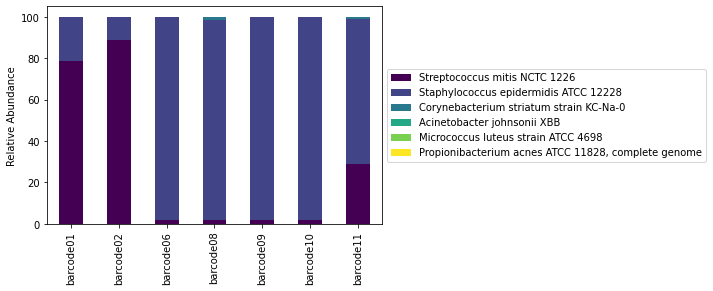


Save figure as: ATCC_skin_4media.png


In [10]:
""" Step 3: Plot Bar Graph showing """
###Extract just the organisms from the entire organism ID:
org_names = []
for org in master_df['organism']:
    tmp = org.split("chromosome")[0].split('.')[1]
    org_names.append(tmp)
org_names = [name.replace("1 ", "") for name in org_names]

""" Step 4: Plot Everything and Save Figure and Dataframe """
fig, ax1 = plt.subplots()
norm_df = master_df.drop('organism',axis=1).transpose().apply(lambda x: x*100/sum(x), axis =1) ###Transposes and normalizes all columns but the organism names
a = norm_df.plot(ax=ax1,kind='bar',stacked=True, colormap = 'viridis')
a.legend(labels = org_names,loc='center left', bbox_to_anchor=(1, 0.5))
a.set_ylabel('Relative Abundance')
plt.show()

name = input('\nSave figure as: ')
fig.savefig(name, bbox_inches = 'tight', dpi=500)
master_df.to_csv(name.split(".")[0] +'_master.csv', index=False, header=True, sep=',')
norm_df.to_csv(name.split(".")[0] +'_norm.csv', index=False, header=True, sep=',')
